In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import logsumexp
from sklearn.model_selection import train_test_split
from abc import ABC, abstractmethod

# Simulate the dataset
np.random.seed(123)
n = 2000

# True mixture weights, means, and standard deviations
weights_true = [0.2, 0.6, 0.2]
mus = [0.3, 0.55, 0.8]
sigmas = [0.05, 0.07, 0.04]

# Draw component labels
comps = np.random.choice(
    [0, 1, 2],
    size=n,
    p=weights_true,
)

# Draw from N(mus[c], sigmas[c]), then truncate to [0,1]
raw = np.random.normal(
    loc=[mus[c] for c in comps],
    scale=[sigmas[c] for c in comps],
)
data = np.clip(raw, 0.0, 1.0)

# Print shape
print(f'data.shape = {data.shape}')

data.shape = (2000,)


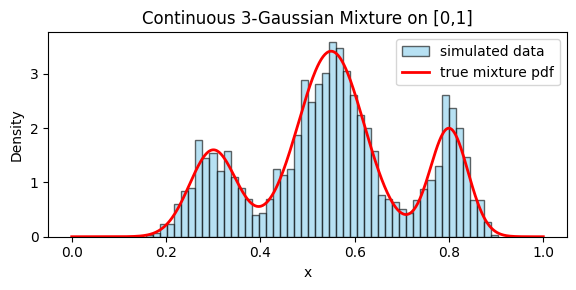

In [2]:
# Visualize the simulated data and true density
plt.figure(figsize=(6, 3))
plt.hist(
    data,
    bins=50,
    density=True,
    alpha=0.6,
    color='skyblue',
    edgecolor='k',
    label='simulated data',
)

# Overlay the true mixture PDF
x_grid = np.linspace(0, 1, 500)

true_pdf = sum(
    w * norm.pdf(x_grid, mu, sigma)
    for w, mu, sigma in zip(weights_true, mus, sigmas)
)

plt.plot(
    x_grid,
    true_pdf,
    'r-',
    lw=2,
    label='true mixture pdf',
)

plt.title('Continuous 3-Gaussian Mixture on [0,1]')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
# Split train/test sets
train_data, test_data = train_test_split(
    data,
    test_size=0.3,
    random_state=0,
)

In [4]:
class GaussianMixtureBase(ABC):
    """Base class for univariate K-component Gaussian mixtures."""

    def __init__(self, n_components: int):
        self.k = n_components
        self.params_: dict[str, float] = {}
        self._is_fitted = False

    @abstractmethod
    def fit(self, data: np.ndarray) -> None:
        """Train the model and populate self.params_ with keys
        'pi0', 'mu0', 'sigma0', ... 'pi{k-1}', 'mu{k-1}', 'sigma{k-1}'."""
        ...

    def predict_log_pdf(self, x: np.ndarray) -> np.ndarray:
        """Plug-in log mixture density at each x."""
        if not self._is_fitted:
            raise RuntimeError("Must call .fit() before predicting.")
        x = np.asarray(x, dtype=float)
        p = np.zeros_like(x)
        for i in range(self.k):
            pi = self.params_[f'pi{i}']
            mu = self.params_[f'mu{i}']
            sigma = self.params_[f'sigma{i}']
            p += pi * norm.pdf(x, mu, sigma)
        # Guard against underflow -> log(0)
        p = np.clip(p, 1e-300, None)
        return np.log(p)

    def posterior_predictive_pdf(self, x: np.ndarray) -> np.ndarray:
        """By default, fall back to plug-in; override in MCMC subclass."""
        return np.exp(self.predict_log_pdf(x))

    def get_params(self) -> dict[str, float]:
        return self.params_

    def evaluate(
        self,
        test_data: np.ndarray,
        kind: str = "plugin",
    ) -> float:
        """Compute the average log-likelihood on `test_data` under the
        already-fitted model."""
        if not self._is_fitted:
            raise RuntimeError("Must call .fit() before evaluating.")
        if kind == "plugin":
            return float(np.mean(self.predict_log_pdf(test_data)))
        elif kind == "ppd":
            pdf = self.posterior_predictive_pdf(test_data)
            return float(np.mean(np.log(np.clip(pdf, 1e-300, None))))
        else:
            raise ValueError("kind must be 'plugin' or 'ppd'")

    def plot_predictive(
        self,
        data: np.ndarray,
        title: str | None = None,
        kind: str = "plugin",
    ) -> None:
        """Overlay the fitted density on a histogram of data."""
        if not self._is_fitted:
            raise RuntimeError("Must call .fit() before plotting.")
        grid = np.linspace(data.min(), data.max(), 500)
        if kind == "plugin":
            density = np.exp(self.predict_log_pdf(grid))
            label = title or "Plug-in fit"
        else:
            density = self.posterior_predictive_pdf(grid)
            label = title or "Posterior-predictive"
        plt.figure(figsize=(6, 3))
        plt.hist(data, bins=50, density=True, alpha=0.4, label="Data")
        plt.plot(grid, density, lw=2, label=label)
        plt.title(title or "Predictive Density Overlay")
        plt.xlabel("x")
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.show()

In [5]:
# MCMC Sampler (Metropolis-Hastings)
class MCMC3G(GaussianMixtureBase):
    """Metropolis-Hastings sampler for a 3-component Gaussian mixture."""

    def __init__(
        self,
        n_samples=20000,
        burn_in=5000,
        seed=0,
        early_stop=False,
        tol=1e-3,
        check_interval=1000,
    ):
        super().__init__(3)
        # Number of MCMC iterations (total draws)
        self.n_samples = n_samples
        # Number of initial draws to discard as burn-in
        self.burn_in = burn_in
        # Seed for random number generator
        self.seed = seed
        # If True, stop early when log-posterior stabilizes
        self.early_stop = early_stop
        # Tolerance for early-stopping criterion
        self.tol = tol
        # How often to check for early stopping
        self.check_interval = check_interval
        # Standard deviations for Gaussian proposals in unconstrained space
        # 3 for mus, 3 for log-sigmas, 2 for logits of pis
        self.scales = np.array([
            0.05, 0.05, 0.05,   # proposals for mus
            0.10, 0.10, 0.10,   # proposals for log(sigmas)
            0.20, 0.20,         # proposals for logits of pis
        ])

    def _logpost(self, theta, data):
        """Compute unnormalized log-posterior with Jacobian adjustments."""
        # Unpack unconstrained parameters
        mus = theta[:3]
        log_sigmas = theta[3:6]
        sigma_vals = np.exp(log_sigmas)
        logits = theta[6:]

        # Recover mixture weights via softmax(logits, 0)
        full_logits = np.r_[logits, 0.0]
        exps = np.exp(full_logits)
        pis = exps / exps.sum()

        # Compute log-likelihood of data under mixture model
        # Use log-sum-exp trick for stability
        log_comp = np.vstack([
            norm.logpdf(data, mu, sigma)
            for mu, sigma in zip(mus, sigma_vals)
        ]).T

        weighted = log_comp + np.log(pis)[None, :]
        log_mix = logsumexp(weighted, axis=1)
        log_lik = log_mix.sum()

        # Add Jacobian terms for the transforms
        # sigma = exp(log_sigmas) and pi = softmax(logits)
        log_jac_sig = log_sigmas.sum()
        log_jac_pi = np.log(pis).sum()

        return log_lik + log_jac_sig + log_jac_pi

    def fit(self, data):
        """Run Metropolis-Hastings sampling, reorder labels, and set params."""
        rng = np.random.default_rng(self.seed)

        # Initialize parameters to break label symmetry
        # Means at 10th, 50th, 90th percentiles
        init_mus = np.sort(np.percentile(data, [10, 50, 90]))
        init_sig = np.std(data) * np.ones(3)
        init_pi = np.ones(3) / 3

        # Convert to logits for the first two weights
        init_logits = np.log(init_pi[:2] / init_pi[2])

        # Pack initial theta vector
        theta = np.r_[
            init_mus,
            np.log(init_sig),
            init_logits,
        ]

        lp = self._logpost(theta, data)
        chain = np.zeros((self.n_samples, theta.size))
        prev_lp = lp

        # Main MCMC loop
        for t in range(self.n_samples):
            # Propose new theta by Gaussian random walk
            proposal = theta + rng.normal(scale=self.scales)
            lp_prop = self._logpost(proposal, data)

            # Accept or reject
            if np.log(rng.random()) < (lp_prop - lp):
                theta, lp = proposal, lp_prop

            chain[t] = theta

            # Early stopping check every check_interval iterations
            if (
                self.early_stop
                and (t + 1) % self.check_interval == 0
                and abs(lp - prev_lp) < self.tol
            ):
                chain = chain[: t + 1]
                break

            prev_lp = lp

            # Progress update
            if (t + 1) % 5000 == 0:
                print(f"[MCMC] iter {t+1}/{self.n_samples}")

        self.chain_ = chain

        # Relabel each draw so that mus are in ascending order
        reordered = []
        for draw in self.chain_:
            mus = draw[:3]
            sigs = np.exp(draw[3:6])
            logits = draw[6:]
            exps = np.exp(np.r_[logits, 0.0])
            pis = exps / exps.sum()
            order = np.argsort(mus)

            sorted_mus = mus[order]
            sorted_sigs = sigs[order]
            sorted_pis = pis[order]
            sorted_logits = np.log(sorted_pis[:2] / sorted_pis[2])

            reordered.append(np.r_[sorted_mus, np.log(sorted_sigs), sorted_logits])

        self.reordered_chain_ = np.vstack(reordered)

        # Compute posterior means of parameters after burn-in
        post = self.reordered_chain_[self.burn_in :]
        mu_vals = post[:, :3].mean(axis=0)
        sig_vals = np.exp(post[:, 3:6]).mean(axis=0)

        # Compute average mixture weights across draws
        exps = np.exp(np.hstack([post[:, 6:], np.zeros((post.shape[0], 1))]))
        pis_draws = exps / exps.sum(axis=1, keepdims=True)
        pi_vals = pis_draws.mean(axis=0)

        # Store parameter estimates
        self.params_ = {}
        for j in range(3):
            self.params_[f"mu{j}"] = mu_vals[j]
            self.params_[f"sigma{j}"] = sig_vals[j]
            self.params_[f"pi{j}"] = pi_vals[j]

        # Mark as fitted
        self._is_fitted = True

    def posterior_predictive_pdf(self, x_grid):
        """Compute Monte Carlo averaged predictive density on x_grid."""
        post = self.reordered_chain_[self.burn_in :]
        pdf = np.zeros_like(x_grid, dtype=float)
        for draw in post:
            mus = draw[:3]
            sigs = np.exp(draw[3:6])
            exps = np.exp(np.r_[draw[6:], 0.0])
            pis = exps / exps.sum()
            pdf += sum(
                pi * norm.pdf(x_grid, mu, sigma)
                for pi, mu, sigma in zip(pis, mus, sigs)
            )
        return pdf / post.shape[0]

    def plot_diagnostics(self):
        """Plot traceplots and marginal posterior histograms."""
        names = [
            "mu0", "mu1", "mu2",
            "log_sigma0", "log_sigma1", "log_sigma2",
            "logit_pi0", "logit_pi1",
        ]

        # Plot raw parameter traces
        plt.figure(figsize=(10, 4))
        for i, name in enumerate(names):
            plt.plot(self.chain_[:, i], lw=0.5, label=name)
        plt.title("MCMC Raw Parameter Traces")
        plt.legend(
            loc="center left",
            bbox_to_anchor=(1.01, 0.5),
            fontsize="small",
        )
        plt.tight_layout(rect=(0, 0, 0.8, 1))
        plt.show()
        print("\n")

        # Plot marginal histograms after relabeling
        fig, axs = plt.subplots(2, 4, figsize=(12, 6))
        axs = axs.flatten()
        for i, name in enumerate(names):
            axs[i].hist(
                self.reordered_chain_[:, i],
                bins=30,
                density=True,
            )
            axs[i].set_title(name)
        plt.suptitle("MCMC Reordered Marginal Posteriors")
        plt.tight_layout()
        plt.show()

In [6]:
# Monte Carlo Expectation–Maximization
class MCEM3G(GaussianMixtureBase):
    """Monte Carlo EM for a 3-component Gaussian mixture."""

    def __init__(
        self,
        n_iter=30,
        n_mc=500,
        eps=1e-6,
        early_stop=False,
        tol=1e-4,
    ):
        super().__init__(3)
        self.n_iter = n_iter
        self.n_mc = n_mc
        self.eps = eps
        self.early_stop = early_stop
        self.tol = tol

    def fit(self, data):
        """Estimate mixture parameters via Monte Carlo EM."""
        rng = np.random.default_rng(0)
        # Initialize means at data percentiles
        mu_vals = np.percentile(data, [10, 50, 90]).astype(float)
        # Initialize standard deviations to overall data std
        sigma_vals = np.std(data) * np.ones(3)
        # Initialize mixture weights uniformly
        pi_vals = np.ones(3) / 3
        # Record parameter history for diagnostics
        self.history_ = []

        # Flatten initial parameters for early-stop check
        prev_params = np.concatenate([mu_vals, sigma_vals, pi_vals])

        for it in range(1, self.n_iter + 1):
            # Monte Carlo E-step: sample latent component indicators Z
            Z = np.zeros((self.n_mc, data.size, 3))
            for m in range(self.n_mc):
                # Compute mixture densities for each component
                dens = np.vstack([
                    pi_vals[k] * norm.pdf(data, mu_vals[k], sigma_vals[k])
                    for k in range(3)
                ]).T
                # Convert densities to sample weights (responsibilities)
                probs = dens / dens.sum(axis=1, keepdims=True)
                # Draw one-hot indicator for each data point
                for i in range(data.size):
                    Z[m, i] = rng.multinomial(1, probs[i])

            # Compute expected responsibilities rbar_i_k = E[Z_i_k]
            rbar = Z.mean(axis=0)
            # M-step: update mixture weights pi_k = Nk / sum(Nk)
            Nk = rbar.sum(axis=0)
            pi_vals = Nk / Nk.sum()

            # M-step: update means and variances
            for k in range(3):
                # Weighted mean
                mu_vals[k] = (rbar[:, k] * data).sum() / Nk[k]
                # Weighted std (with floor at eps)
                var = (rbar[:, k] * (data - mu_vals[k])**2).sum() / Nk[k]
                sigma_vals[k] = np.sqrt(var)
            sigma_vals = np.maximum(sigma_vals, self.eps)

            # Save current estimates
            self.history_.append((
                mu_vals.copy(),
                sigma_vals.copy(),
                pi_vals.copy(),
            ))

            # Check for convergence if enabled
            if self.early_stop:
                curr = np.concatenate([mu_vals, sigma_vals, pi_vals])
                max_change = np.max(np.abs(curr - prev_params))
                if max_change < self.tol:
                    print(f"[MCEM] early stopping at iter {it}")
                    break
                prev_params = curr

            print(
                f"[MCEM] iter {it}/{self.n_iter}"
                f" | pi={pi_vals.round(3)}, mu={mu_vals.round(3)}"
            )

        # Store final parameters in self.params_
        for comp in range(3):
            self.params_[f"mu{comp}"] = mu_vals[comp]
            self.params_[f"sigma{comp}"] = sigma_vals[comp]
            self.params_[f"pi{comp}"] = pi_vals[comp]

        # Mark as fitted
        self._is_fitted = True

    def plot_diagnostics(self):
        """Plot parameter trajectories across EM iterations."""
        # Prepare iteration indices and histories
        its = np.arange(1, len(self.history_) + 1)
        mu_hist = np.array([h[0] for h in self.history_])
        sigma_hist = np.array([h[1] for h in self.history_])
        pi_hist = np.array([h[2] for h in self.history_])

        plt.figure(figsize=(10, 4))
        # Plot each component's mean, sigma, and weight
        for comp in range(3):
            plt.plot(
                its,
                mu_hist[:, comp],
                'o-',
                label=f"mu{comp}"
            )
            plt.plot(
                its,
                sigma_hist[:, comp],
                's--',
                label=f"sigma{comp}"
            )
            plt.plot(
                its,
                pi_hist[:, comp],
                'd:',
                label=f"pi{comp}"
            )

        plt.xlabel("Iteration")
        plt.ylabel("Parameter value")
        plt.title("MCEM Parameter Convergence")
        plt.legend(
            loc="center left",
            bbox_to_anchor=(1.01, 0.5),
            fontsize="small"
        )
        plt.tight_layout(rect=(0, 0, 0.8, 1))
        plt.show()

In [7]:
# Classic Expectation–Maximization
class EM3G(GaussianMixtureBase):
    """Classic EM for fitting a 3-component univariate Gaussian mixture."""

    def __init__(
        self,
        tol=1e-6,
        max_iter=100,
        eps=1e-6,
    ):
        super().__init__(3)
        # Convergence tolerance on log-likelihood improvement
        self.tol = tol
        # Maximum number of EM iterations
        self.max_iter = max_iter
        # Small floor on sigma to avoid numerical issues
        self.eps = eps

    def fit(self, data):
        """
        Fit the mixture model via the standard EM algorithm:
            E-step: compute responsibilities (soft assignments)
            M-step: update weights, means, and variances
            Convergence: stop when log-likelihood change < tol
        """
        N = data.size
        # Initialize component means at empirical percentiles
        mu_vals = np.percentile(data, [10, 50, 90]).astype(float)
        # Initialize all sigmas to the overall sample standard deviation
        sigma_vals = np.std(data) * np.ones(3)
        # Start with equal mixture weights
        pi_vals = np.ones(3) / 3

        ll_old = None
        # Store log-likelihood history for diagnostics
        self.ll_history = []

        for it in range(self.max_iter):
            # --- E-step ---
            # Compute weighted densities for each component (shape N x 3)
            dens = np.vstack([
                pi_vals[k] * norm.pdf(data, mu_vals[k], sigma_vals[k])
                for k in range(3)
            ]).T
            # Normalize to get responsibilities r_ik
            resp = dens / dens.sum(axis=1, keepdims=True)

            # --- M-step ---
            # Effective counts per component
            Nk = resp.sum(axis=0)
            # Update mixture weights pi_k = Nk / N
            pi_vals = Nk / N
            # Update means mu_k = sum_i r_ik * x_i / Nk
            mu_vals = (resp * data[:, None]).sum(axis=0) / Nk
            # Update variances sigma^2_k = sum_i r_ik * (x_i - mu_k)**2 / Nk
            var_vals = (resp * (data[:, None] - mu_vals)**2).sum(axis=0) / Nk
            sigma_vals = np.sqrt(var_vals)
            # Enforce a minimum sigma for stability
            sigma_vals = np.maximum(sigma_vals, self.eps)

            # --- Log-likelihood and convergence check ---
            # Compute current log-likelihood under the mixture
            ll = np.sum(np.log((resp * Nk).sum(axis=1) / N))
            self.ll_history.append(ll)
            if ll_old is not None and abs(ll - ll_old) < self.tol:
                # Stop if improvement is below tolerance
                break
            ll_old = ll

        # Store final parameter estimates
        for comp in range(3):
            self.params_[f"mu{comp}"] = mu_vals[comp]
            self.params_[f"sigma{comp}"] = sigma_vals[comp]
            self.params_[f"pi{comp}"] = pi_vals[comp]

        print(
            f"[EM] Converged in {it+1} iterations;"
            f" pi={pi_vals.round(3)}, mu={mu_vals.round(3)}"
        )

        # Mark as fitted
        self._is_fitted = True

    def plot_diagnostics(self):
        """Plot EM log-likelihood convergence."""
        plt.figure(figsize=(6, 4))
        plt.plot(
            self.ll_history,
            marker='o',
            linestyle='-',
        )
        plt.xlabel('EM Iteration')
        plt.ylabel('Log-Likelihood')
        plt.title('EM Convergence')
        plt.tight_layout()
        plt.show()

In [8]:
# Initialize the models
models = [
    MCMC3G(early_stop=False),
    MCEM3G(early_stop=False),
    EM3G(),
]
names = ['MCMC', 'MCEM', 'EM']

=== MCMC ===
[MCMC] iter 5000/20000
[MCMC] iter 10000/20000
[MCMC] iter 15000/20000
[MCMC] iter 20000/20000




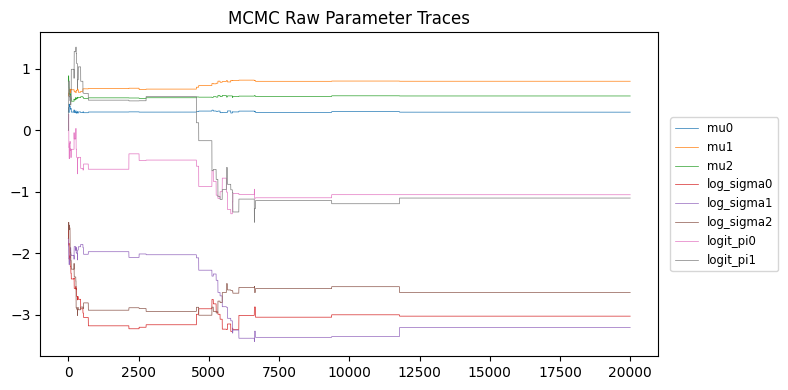

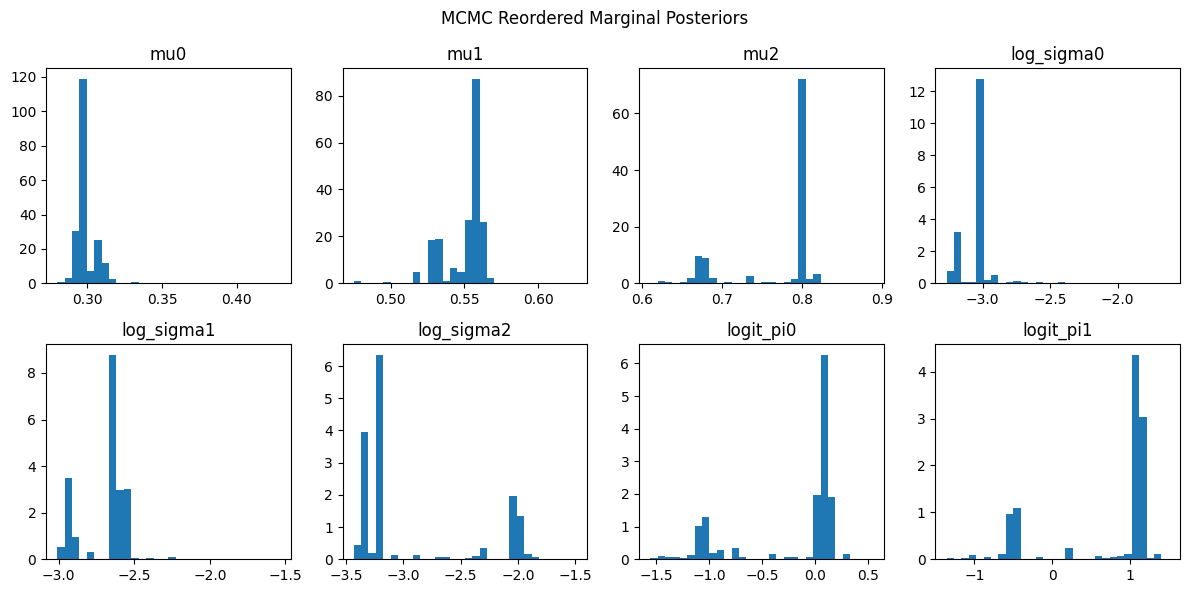



=== MCEM ===
[MCEM] iter 1/30 | pi=[0.279 0.431 0.29 ], mu=[0.402 0.559 0.703]
[MCEM] iter 2/30 | pi=[0.28  0.429 0.291], mu=[0.4   0.559 0.704]
[MCEM] iter 3/30 | pi=[0.281 0.428 0.291], mu=[0.398 0.56  0.706]
[MCEM] iter 4/30 | pi=[0.281 0.428 0.291], mu=[0.396 0.56  0.708]
[MCEM] iter 5/30 | pi=[0.281 0.43  0.289], mu=[0.394 0.56  0.71 ]
[MCEM] iter 6/30 | pi=[0.28  0.432 0.288], mu=[0.392 0.56  0.711]
[MCEM] iter 7/30 | pi=[0.28  0.432 0.288], mu=[0.391 0.56  0.714]
[MCEM] iter 8/30 | pi=[0.28  0.434 0.287], mu=[0.389 0.56  0.716]
[MCEM] iter 9/30 | pi=[0.28  0.434 0.286], mu=[0.386 0.56  0.719]
[MCEM] iter 10/30 | pi=[0.279 0.436 0.285], mu=[0.384 0.56  0.722]
[MCEM] iter 11/30 | pi=[0.278 0.438 0.284], mu=[0.381 0.559 0.725]
[MCEM] iter 12/30 | pi=[0.278 0.44  0.282], mu=[0.377 0.559 0.73 ]
[MCEM] iter 13/30 | pi=[0.277 0.441 0.281], mu=[0.373 0.558 0.735]
[MCEM] iter 14/30 | pi=[0.276 0.444 0.279], mu=[0.368 0.557 0.742]
[MCEM] iter 15/30 | pi=[0.275 0.447 0.278], mu=[0.363 0.

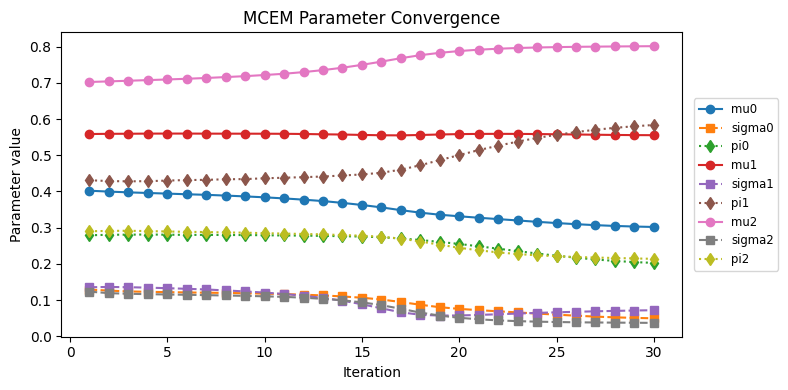



=== EM ===
[EM] Converged in 90 iterations; pi=[0.196 0.595 0.21 ], mu=[0.299 0.555 0.803]




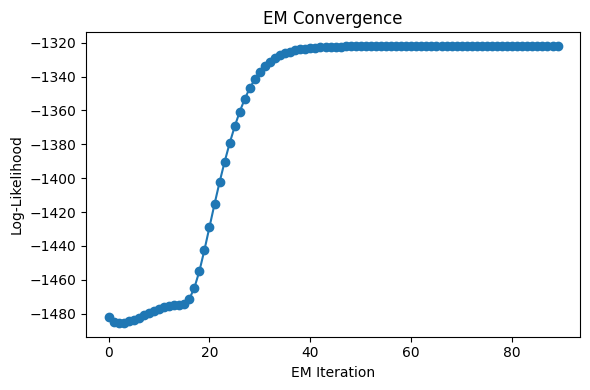

In [9]:
# Fit the models and plot diagnostics
for mdl, name in zip(models, names):
    print(f"=== {name} ===")
    mdl.fit(train_data)
    print("\n")
    mdl.plot_diagnostics()
    print("\n")

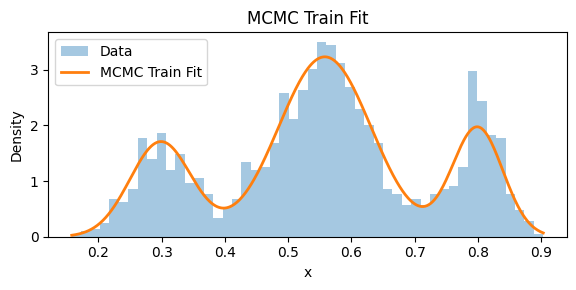

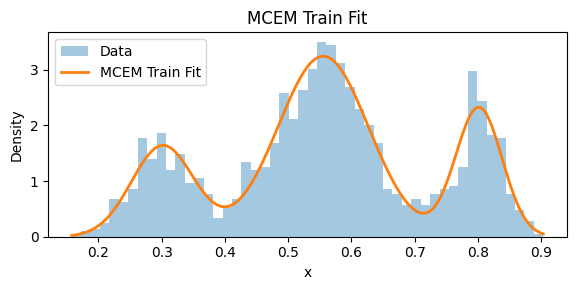

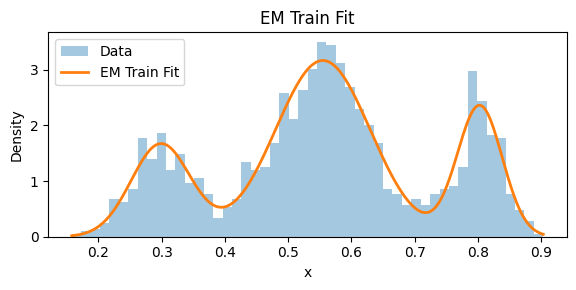

In [10]:
# Plot evaluation
for mdl, name in zip(models, names):
    mdl.plot_predictive(
        data=train_data,
        kind='plugin',
        title=f"{name} Train Fit"
    )
    print("\n")

In [11]:
# Print evaluation metrics
print("=== Test Set Avg Log-Likelihood ===")
for mdl, name in zip(models, names):
    ll = mdl.evaluate(
        test_data=test_data,
        kind='plugin',
    )
    print(f"{name:4s} | avg log-lik = {ll:.3f}")

=== Test Set Avg Log-Likelihood ===
MCMC | avg log-lik = 0.557
MCEM | avg log-lik = 0.562
EM   | avg log-lik = 0.561


In [12]:
# Compute the average log-likelihood for each model
records = []
for mdl, name in zip(models, names):
    records.append({
        'Model': name,
        'Avg LL': mdl.evaluate(test_data, kind='plugin')
    })

# Convert to a DataFrame
ll_df = pd.DataFrame(records)
display(ll_df.round(3))

,Model,Avg LL
0,MCMC,0.557
1,MCEM,0.562
2,EM,0.561


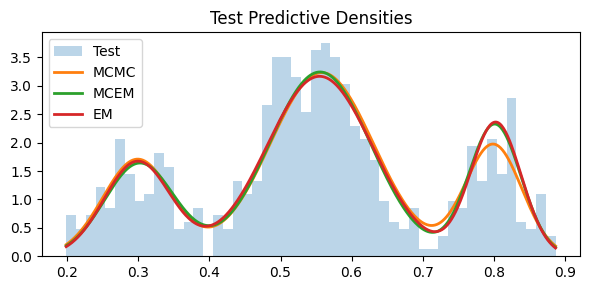

In [13]:
# Plot predictive densities
plt.figure(figsize=(6, 3))
plt.hist(
    test_data,
    bins=50,
    density=True,
    alpha=0.3,
    label='Test',
)

grid = np.linspace(test_data.min(), test_data.max(), 500)

for mdl, name in zip(models, names):
    plt.plot(
        grid,
        np.exp(mdl.predict_log_pdf(grid)),
        lw=2,
        label=name,
    )

plt.title('Test Predictive Densities')
plt.legend()
plt.tight_layout()
plt.show()